# Homework4: VAE limitations

## Task 1: Theory (4pt)

### Problem 1: Discrete vs continuous model (2pt)
Let's suppose we have 2 generative models for images of size $W \times H \times C$, where $W$ - image width, $H$ - image height, $C$ - number of channels. 

* The first model $p_1(\mathbf{x} | \boldsymbol{\theta})$ outputs a discrete distribution for each pixel  $\text{Categorical}(\boldsymbol{\pi})$, где $\boldsymbol{\pi} = (\pi_1, \dots,  \pi_{256})$. 

* The second model $p_2(\mathbf{x} | \boldsymbol{\theta})$ models a discrete distribution by a continuous mixture of logistic functions ($\boldsymbol{\pi}$ - mixing distribution):
$$
    P(x | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}) = P(x + 0.5 | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}) - P(x - 0.5 | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}).
$$

$$
    p(\nu | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}) = \sum_{k=1}^K \pi_k p(\nu | \mu_k, s_k).
$$

Each of the models outputs parameters of pixel distributions.

* Calculate the dimensions of the output tensor for the model $p_1(\mathbf{x} | \boldsymbol{\theta})$ and for the model $p_2(\mathbf{x} | \boldsymbol{\theta})$. 


   - Модель $p_1$ - $(\text{Batch_size}, C, W, H, 256)$, 256 - количество категорий
   - Модель $p_2$ - $(\text{Batch_size}, C, W, H, 3 \cdot K)$, 3 - $\mu$, $\sigma$ и $\pi, $K$ - количество компонент$

* At what number of mixture components $K$ is the number of elements of the output tensor for $p_2(\mathbf{x} | \boldsymbol{\theta})$ becomes greater than $p_1(\mathbf{x} | \boldsymbol{\theta})$.

- Начиная с $K = ceil(256 // 3) = 86$ компонент

# Task 2: VAE with Autoregressive decoder on MNIST (4pt)

In this task you will fit the VAE model with [autoregressive decoder](https://arxiv.org/abs/1611.05013) to the MNIST dataset. We discussed this topic at Lecture 4.


Download the data from [here](https://drive.google.com/file/d/1eTH_3i6yShm5yQikO0KdDEG3Hue9lNoZ/view?usp=sharing) (you could use the cell below).

## Libraries and data

In [1]:
# REPO_NAME = "2022-2023-DGM-AIMasters-course"
# !if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
# !git clone https://github.com/r-isachenko/{REPO_NAME}.git
# !cd {REPO_NAME}
# !pip install ./{REPO_NAME}/homeworks/
# !rm -Rf {REPO_NAME}

In [2]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import show_samples, visualize_images, load_pickle

In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

USE_CUDA = torch.cuda.is_available()

In [4]:
torch.cuda.empty_cache()

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !gdown 1eTH_3i6yShm5yQikO0KdDEG3Hue9lNoZ

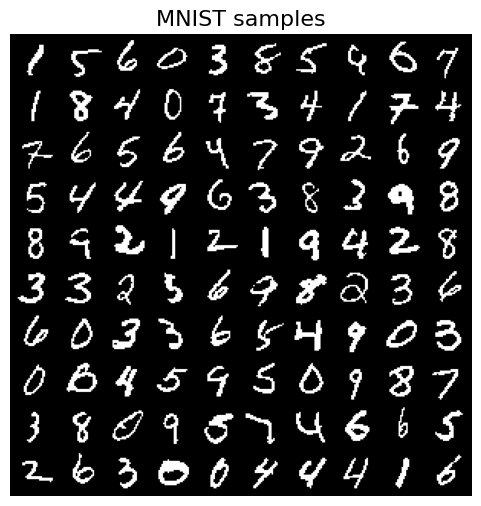

In [7]:
train_data, test_data = load_pickle('mnist.pkl', flatten=False, binarize=True)
# train_data, test_data = load_pickle('./mnist.pkl', flatten=False, binarize=True)
visualize_images(train_data, 'MNIST samples')

## Implementation

First of all, let implement the helper functions.

In [8]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standart normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    # ====
    # from hw2
    KL_part1 = log_std_2 - log_std_1 - 0.5
    KL_part2 = (torch.exp(log_std_1) ** 2 + (mean_1 - mean_2) ** 2) / (2 * torch.exp(log_std_2) ** 2)
    return KL_part1 + KL_part2
    # ====


def test_KL():
    assert np.isclose(get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)).numpy(), 200.2144, rtol=1e-3)
    assert np.isclose(get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)).numpy(), 1.50925, rtol=1e-3)
    assert np.allclose(get_normal_KL(torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))).numpy(), [49.2990, 1498.479], rtol=1e-3)

test_KL()

We will use PixelCNN model as the VAE decoder.

First of all we need implement masked convolution 2d layer for autoregressive decoder. It is totally the same as the layer that we used in homework 1.

However, there is a slight difference. Here, we need to model the distribution 
$$
    p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \prod_{j=1}^m p(x_j | \mathbf{x}_{1:j-1}, \mathbf{z}, \boldsymbol{\theta}).
$$
Each conditional $p(x_j | \mathbf{x}_{1:j-1}, \mathbf{z}, \boldsymbol{\theta})$ is conditioned on the latent variable $\mathbf{z}$.

To implement this conditioning we will pass $\mathbf{z}$ to our MaskedConv2d. There we will apply Linear layer to $\mathbf{z}$ and then add it to the output of masked convolution. 

In [9]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=5, padding=0, conditional_size=None):
        assert mask_type in ['A', 'B']
        super().__init__(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                         padding=padding)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

        if conditional_size is not None:
            self.cond_op = nn.Linear(conditional_size, self.out_channels)

    def forward(self, input, cond=None):
        # ====
        # apply masked convolution and get "out" variable
        self.weight.data *= self.mask
        out = super(MaskedConv2d, self).forward(input)
        # ====
        
        if cond is not None:
            cond = self.cond_op(cond)
            out = out + cond.view(cond.shape[0], self.out_channels, 1, 1)
        
        return out

    def create_mask(self, mask_type):
        # ====
        # do not forget about mask_type
        # from hw1
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0
        # ====


def test_masked_conv2d():
    layer = MaskedConv2d('A', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d('B', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

[Layer Normalization](https://arxiv.org/abs/1607.06450) helps to stabilize training process.

In [10]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters):
        super().__init__(n_filters)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

Let implement PixelCNN model.

In [11]:
class PixelCNN(nn.Module):
    def __init__(
        self, 
        input_shape, 
        n_filters=256, 
        kernel_size=3, 
        n_layers=7,
        use_layer_norm=True,
        conditional_size=None
    ):
        super().__init__()
        self.input_shape = input_shape
        padding = kernel_size // 2
        
        # ====
        # apply the sequence of MaskedConv2d -> LayerNorm -> ReLU
        # note that the first conv layer should be of type 'A'
        # the last layer should be MaskedConv2d
        # define self.net as list of layers
        
        def net_block(mask_type,
                      in_channels,
                      out_channels,
                      n_filters,
                      kernel_size,
                      padding,
                      conditional_size,
                      use_layer_norm):
            block = []
            block.append(MaskedConv2d(mask_type,
                                      in_channels,
                                      out_channels,
                                      kernel_size,
                                      padding,
                                      conditional_size,))
            if use_layer_norm:
                block.append(LayerNorm(n_filters))
            block.append(nn.ReLU(inplace=True))
            return block
        
        self.net = []
        
        self.net.extend(net_block(mask_type='A',
                                  in_channels=1, 
                                  out_channels=n_filters,
                                  n_filters=n_filters,
                                  kernel_size=kernel_size,
                                  padding=padding,
                                  conditional_size=conditional_size,
                                  use_layer_norm=use_layer_norm))
        
        for _ in range(n_layers - 2):
            self.net.extend(net_block(mask_type='B',
                                      in_channels=n_filters, 
                                      out_channels=n_filters,
                                      n_filters=n_filters,
                                      kernel_size=kernel_size,
                                      padding=padding,
                                      conditional_size=conditional_size,
                                      use_layer_norm=use_layer_norm))
        
        self.net.extend([MaskedConv2d(mask_type='B',
                                        in_channels=n_filters,
                                        out_channels=2,
                                        kernel_size=kernel_size,
                                        padding=padding,
                                        conditional_size=conditional_size)])
        
        self.net = nn.Sequential(*self.net)
        # ====

    def forward(self, x, cond=None):
        out = (x.float() - 0.5) * 2
        for layer in self.net:
            if isinstance(layer, MaskedConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out.view(x.shape[0], 2, 1, *self.input_shape)

    def loss(self, x, cond=None):
        # ====
        total_loss = F.cross_entropy(self(x, cond=cond), x.long())
        return {'total_loss': total_loss}
        # ====

    def sample(self, n, cond=None):
        # read carefully the sampling process
        samples = torch.zeros(n, 1, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples, cond=cond)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()

We will use simple convolutional encoder here. Look carefully.

In [12]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[0] // 4 * input_shape[1] // 4 * 64
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        x = (x.float() - 0.5) * 2
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std

Now it is time to implement the whole model.

In [13]:
class ARDecoderVAE(nn.Module):
    def __init__(self, input_shape, n_latent, free_bits=None):
        super().__init__()
        assert len(input_shape) == 2

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.free_bits = free_bits
        self.encoder = ConvEncoder(input_shape, n_latent)
        self.decoder = PixelCNN(
            input_shape, 
            n_filters=32, 
            n_layers=3,
            kernel_size=7, 
            conditional_size=n_latent
        )

    def prior(self, n):
        # ====
        # return n samples from prior distribution (we use standart normal for prior)
        p = Normal(torch.zeros(self.n_latent), torch.ones(self.n_latent))
        samples = p.sample((n,)).cuda()
        
        return samples
        # ====

    def loss(self, x):
        # ====
        # 1) apply encoder
        # 2) apply reparametrization trick
        # 3) get decoder loss (reconstruction loss)
        # 4) get kl loss using get_normal_KL
        # 5) apply free_bits
        mu_z, log_std_z = self.encoder(x)
        z = torch.exp(log_std_z) * self.prior(x.shape[0]) + mu_z
        
        recon_loss = torch.sum(self.decoder.loss(x, z).get('total_loss'))
        kl_loss = torch.sum(torch.clip(get_normal_KL(mu_z, log_std_z), max=self.free_bits)) 
        
        # ====

        return {
            'total_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n):
        with torch.no_grad():
            z = self.prior(n).cuda()
            samples = self.decoder.sample(n, cond=z)
        return samples

  0%|          | 0/5 [00:00<?, ?it/s]

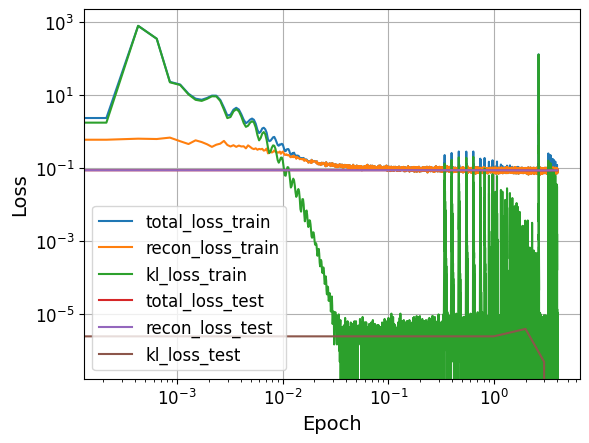

In [14]:
# ====
# choose these parameters
BATCH_SIZE = 16 # any adequate value
EPOCHS = 5     # < 10 
LR = 4e-3         # < 1e-2
FREE_BITS = 4  # < 10
# ====

train_data, test_data = load_pickle('mnist.pkl', binarize=True)

model = ARDecoderVAE(input_shape=(28, 28), free_bits=FREE_BITS, n_latent=16)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, 
                                        use_cuda=USE_CUDA, use_tqdm=True, lr=LR)

plot_training_curves(train_losses, test_losses, True, True)

Note that sampling from our model is sequential now.

total_loss: 0.0854
recon_loss: 0.0854
kl_loss: -0.0000


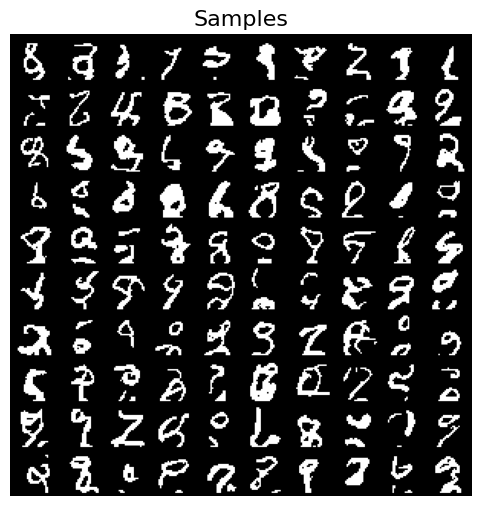

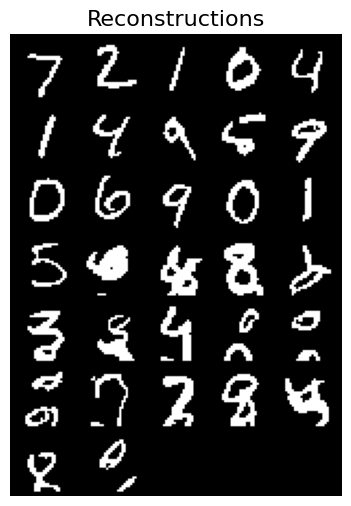

In [15]:
samples = model.sample(100)

x = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    z, _ = model.encoder(2 * x - 1)
    x_recon = model.decoder.sample(min(50, BATCH_SIZE), cond=z)
x = x.cpu().numpy()
reconstructions = np.concatenate((x, x_recon), axis=0)

samples = samples.astype('float32')
reconstructions = reconstructions.astype('float32')

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')

# Task 3: VAE with Autoregressive flow-based prior on CIFAR10 (5pt)

In this task you will fit the VAE model with [flow-based prior](https://arxiv.org/abs/1611.02731) to the CIFAR10 dataset. We discussed this topic at Lecture 7.

Download the data from [here](https://drive.google.com/file/d/1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj/view?usp=sharing) (you could use the cell below).

In [16]:
# !gdown 1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj

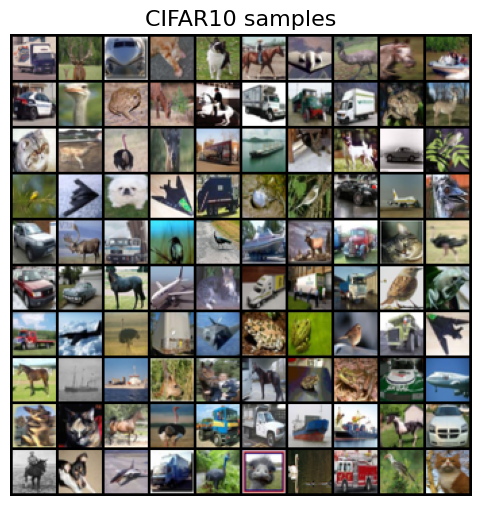

In [17]:
# train_data, test_data = load_pickle('/content/cifar10.pkl')
train_data, test_data = load_pickle('cifar10.pkl')
visualize_images(train_data, 'CIFAR10 samples')

The model consists of:
* convolutional encoder (variational posterior destrituion $q(\mathbf{z} | \mathbf{x})$);
* convolutional decoder (generative distribution $p(\mathbf{x} | \mathbf{z})$);
* autoregressive prior.

We will use MADE model as autoregressive prior. MADE Autoregressive frow (mapping from $\mathbf{z}\rightarrow \boldsymbol{\epsilon}$) should output location $\mu_{\boldsymbol{\lambda}}(\mathbf{z})$ and scale parameters $\sigma_\boldsymbol{\lambda}(\mathbf{z})$. The mapping from $\mathbf{z}$ to $\boldsymbol{\epsilon}$ has the form:
$$
    \boldsymbol{\epsilon} = f(\mathbf{z}, \boldsymbol{\lambda}) = \mathbf{z} * \sigma_\boldsymbol{\lambda}(\mathbf{z}) + \mu_{\boldsymbol{\lambda}}(\mathbf{z}).
$$

The ELBO objective in this task is:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}, \boldsymbol{\lambda}) = E_{q(\mathbf{z}|\mathbf{x}, \boldsymbol{\phi})}[\log{p(\mathbf{x}|\mathbf{z}, \boldsymbol{\theta})}] - E_{q(\mathbf{z}|\mathbf{x}, \boldsymbol{\phi})}[\log{q(\mathbf{z}|\mathbf{x}, \boldsymbol{\phi})} - \log{p(\mathbf{z} | \boldsymbol{\lambda})}]
$$
where the logarithm of prior distribution is given by chage of variable (CoV) theorem
$$
    \log{p(\mathbf{z} | \boldsymbol{\lambda})} = \log{p(\boldsymbol{\epsilon})} + \log{\left|\det\left(\frac{d\boldsymbol{\epsilon}}{d\mathbf{z}}\right)\right|} = \log{p(f(\mathbf{z}, \boldsymbol{\lambda}))} + \log{\left|\det\left(\frac{\partial f(\mathbf{z}, \boldsymbol{\lambda})}{\partial \mathbf{z}}\right)\right|}.
$$

Here we define convolutional encoder and decoder. You could use this architecture or experiment with it.

In [18]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.fc = nn.Linear(conv_out_dim, 2 * n_latent)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std
        

class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(n_latent, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        return self.deconvs(out)

For autoregressive prior we will use MADE model. Do not change these classes, but read it carefully.

In [19]:
class MaskedLinear(nn.Linear):
    # do not change this class
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    # do not change this class
    def __init__(self, input_shape, d, hidden_size=[512, 512]):
        super().__init__()
        self.input_shape = input_shape
        self.nin = np.prod(input_shape)
        self.nout = self.nin * d
        self.d = d
        self.hidden_sizes = hidden_size
        self.ordering = np.arange(self.nin)

        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()
        self.net = nn.ModuleList(self.net)

        self.m = {}
        self.create_mask()

    def create_mask(self):
        L = len(self.hidden_sizes)

        self.m[-1] = self.ordering
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(),
                                          self.nin - 1, size=self.hidden_sizes[l])

        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        masks[-1] = np.repeat(masks[-1], self.d, axis=1)

        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x):
        batch_size = x.shape[0]
        out = x.view(batch_size, self.nin)
        for layer in self.net:
            out = layer(out)
        out = out.view(batch_size, self.nin, self.d)
        return out

Let implement VAE with autoregressive prior model.

In [20]:
class ARFPriorVAE(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        assert len(input_shape) == 3
        self.input_shape = input_shape
        self.n_latent = n_latent

        # ====
        # define made model, encoder and decoder
        self.model = MADE(n_latent, 2)   #
        self.encoder = ConvEncoder(input_shape, n_latent)
        self.decoder = ConvDecoder(n_latent, input_shape)

        # ====

    def loss(self, x, beta=1e-7):
        x = 2 * x.float() - 1

        # ====
        # 1) apply encoder to x to get variational posterior distribution parameters
        # 2) sample z from variational posterior distribution (reparametrization trick)
        # 3) apply decoder to get reconstruction
        mu_z, log_std_z = self.encoder(x)
        z = torch.exp(log_std_z) * self.prior(x.shape[0]) + mu_z
        recon = self.decoder(z)

        # ====

        # ====
        # 1) compute reconstruction loss (first term in ELBO) 
        # in this case we could use mse loss 
        # (we will get beta-VAE model since the contributions of reconstruction loss and KL term become dishonest) 
        # 2) compute encoder log prob (it is a log of normal distribution on z)
        # 3) apply MADE model to z to get mu and log_std
        recon_loss = torch.sum(nn.MSELoss()(x, recon))
        enc_log_prob = Normal(mu_z, torch.exp(log_std_z)).log_prob(z)
        mu, log_std = self.model(z).chunk(2, dim=-1)

        # ====

        # this trick is just for model stability (do not touch it)
        log_std = torch.tanh(log_std.squeeze(-1))

        # ====
        # 1) scale z to sigma and shift to mu to get epsilon
        # 2) compute prior log prob (log of standart normal)
        # 3) kl loss is difference between encoder log prob and prior log prob
        epsilon = z * torch.exp(log_std) + mu.squeeze(-1)
        log_det = (1 - log_std ** 2) * torch.atan(log_std)
        print(log_det.sum())
        prior_log_prob = Normal(mu.squeeze(-1), torch.exp(log_std)).log_prob(epsilon) + log_det
        
        kl_loss = beta * torch.sum(enc_log_prob - prior_log_prob)

        # ====
        return {
            'total_loss': recon_loss + kl_loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }
    
    def prior(self, n, use_cuda=True):
        # ====
        # return n samples from prior distribution (we use standard normal for prior)
        p = Normal(torch.zeros(self.n_latent), torch.ones(self.n_latent))
        z = p.sample((n,))

        # ====
        if use_cuda:
            z = z.cuda()
        return z

    def sample(self, n):
        with torch.no_grad():
            z = self.prior(n)
            # investigate how to sample from autoregressive model (do not change this part)
            for i in range(self.n_latent):
                mu, log_std = self.model(z)[:, i].chunk(2, dim=-1)
                log_std = torch.tanh(log_std)
                mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
                z[:, i] = (z[:, i] - mu) * torch.exp(-log_std)
            return self.decoder(z).cpu().numpy() * 0.5 + 0.5

  0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.6546, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3325, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6820, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9763, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7138, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7812, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7758, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7563, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6028, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8552, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7374, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3107, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4628, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1496, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3466, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.2316, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0405, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.5533, device='cuda:0',

tensor(-19.3757, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-19.0425, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-16.3736, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-17.3888, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-16.8180, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-16.9277, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-14.9959, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-16.5234, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-15.3398, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-15.3167, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-13.8806, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-12.0758, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-12.6546, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-13.3839, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.7416, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-10.3283, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-12.0698, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.5104,

tensor(-2.8762, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0075, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.1828, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.4692, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.7503, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.9489, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5007, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7859, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9011, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.3453, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.8333, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.8526, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-6.3205, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-6.4622, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-6.5898, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-6.8354, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-7.0300, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-6.6705, device='cuda:0'

tensor(-2.8814, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0628, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.1616, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8640, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2004, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.1730, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.1732, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0011, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.1923, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.1095, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.9819, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8380, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3060, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2482, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3032, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.1512, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2867, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.1620, device='cuda:0'

tensor(-4.5027, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.1783, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.6041, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.8856, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5974, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.8256, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.6392, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3440, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7890, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.8236, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.6453, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7150, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7823, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.2507, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.0566, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7003, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.6217, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5868, device='cuda:0'

tensor(-10.4406, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.5472, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.1037, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-10.0569, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-8.6918, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.3277, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.3115, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.2143, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-8.8185, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-8.3753, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.1789, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.0860, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-8.4910, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.4309, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.1405, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-8.3262, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-8.9655, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-8.9453, device='cuda:

tensor(-5.5456, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5565, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6156, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.9155, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.8003, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6644, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.9764, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5879, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-6.2591, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4369, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5332, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-6.1799, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4933, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.3230, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5838, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.3766, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-6.0690, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7188, device='cuda:0'

tensor(-5.6601, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5939, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.8949, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7433, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6436, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7349, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7357, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7675, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6218, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7831, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7927, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6018, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5718, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7029, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7328, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6702, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6240, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6907, device='cuda:0'

tensor(-5.6893, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6637, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6707, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7194, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7078, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7047, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7597, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6455, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7075, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6516, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7142, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7567, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6453, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6524, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6383, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6638, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6369, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.7674, device='cuda:0'

tensor(-5.6139, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6170, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6521, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5944, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6162, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6458, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6281, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6035, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5925, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5859, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5596, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5708, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6403, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6052, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5961, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5898, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6576, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.6677, device='cuda:0'

tensor(-5.5082, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4580, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4455, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.5146, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4740, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4746, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4365, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4444, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4911, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4557, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4668, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4684, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4421, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4578, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4539, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4282, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4416, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.4322, device='cuda:0'

tensor(-5.2645, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2729, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2411, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2625, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2437, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2378, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2257, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2421, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2147, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2060, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2253, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2236, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2218, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2476, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2102, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2318, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.1997, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.2148, device='cuda:0'

tensor(-5.0074, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9975, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.0063, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9939, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.0298, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9942, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9985, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.0125, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9914, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.0120, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9904, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9863, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9912, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-5.0028, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9790, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9980, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9961, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.9935, device='cuda:0'

tensor(-4.7754, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7779, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.8041, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7820, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.8006, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7744, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7592, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7795, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7669, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7737, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7662, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7712, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7636, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7375, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7548, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7646, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7519, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.7638, device='cuda:0'

tensor(-4.5690, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5395, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5556, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5372, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5302, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5488, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5278, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5344, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5581, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5319, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5253, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5425, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5287, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5298, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5373, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5311, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5245, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.5271, device='cuda:0'

tensor(-4.3149, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3061, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3200, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3178, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3080, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3113, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3105, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3045, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3030, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3194, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3089, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3040, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3050, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3136, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.2958, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.3144, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.2997, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.2964, device='cuda:0'

tensor(-4.0704, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0874, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0743, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0758, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0588, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0588, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0613, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0553, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0553, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0660, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0547, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0706, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0538, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0550, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0588, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0437, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0526, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-4.0687, device='cuda:0'

tensor(-3.8433, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8525, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8474, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8697, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8333, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8416, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8349, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8341, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8493, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8303, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8470, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8273, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8250, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8223, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8334, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8222, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8243, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.8279, device='cuda:0'

tensor(-3.6388, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6211, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6248, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6202, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6183, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6172, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6080, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6103, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6063, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6117, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6106, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6102, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6134, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6049, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6067, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.6033, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.5970, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.5939, device='cuda:0'

tensor(-3.4266, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.4131, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.4082, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.4107, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.4111, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.4074, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.4000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.4031, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3970, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3995, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3944, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.4001, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3969, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3990, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3915, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3984, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3912, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.3900, device='cuda:0'

tensor(-3.2275, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2270, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2227, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2231, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2307, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2231, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2188, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2193, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2225, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2190, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2136, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2206, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2188, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2132, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2119, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2077, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2111, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.2030, device='cuda:0'

tensor(-3.2062, device='cuda:0')
tensor(-3.2111, device='cuda:0')
tensor(-3.2043, device='cuda:0')
tensor(-3.2110, device='cuda:0')
tensor(-3.2073, device='cuda:0')
tensor(-3.2032, device='cuda:0')
tensor(-3.2102, device='cuda:0')
tensor(-3.2097, device='cuda:0')
tensor(-3.1982, device='cuda:0')
tensor(-3.2052, device='cuda:0')
tensor(-3.2052, device='cuda:0')
tensor(-3.2009, device='cuda:0')
tensor(-3.2056, device='cuda:0')
tensor(-3.2051, device='cuda:0')
tensor(-3.2086, device='cuda:0')
tensor(-3.2013, device='cuda:0')
tensor(-3.2071, device='cuda:0')
tensor(-3.2028, device='cuda:0')
tensor(-3.2080, device='cuda:0')
tensor(-3.2027, device='cuda:0')
tensor(-3.2133, device='cuda:0')
tensor(-3.2037, device='cuda:0')
tensor(-3.2062, device='cuda:0')
tensor(-3.2078, device='cuda:0')
tensor(-3.2116, device='cuda:0')
tensor(-3.1971, device='cuda:0')
tensor(-3.2103, device='cuda:0')
tensor(-3.2093, device='cuda:0')
tensor(-3.2047, device='cuda:0')
tensor(-3.1986, device='cuda:0')
tensor(-3.

tensor(-3.2041, device='cuda:0')
tensor(-3.1994, device='cuda:0')
tensor(-3.2082, device='cuda:0')
tensor(-3.2054, device='cuda:0')
tensor(-3.2063, device='cuda:0')
tensor(-3.2147, device='cuda:0')
tensor(-3.2120, device='cuda:0')
tensor(-3.2034, device='cuda:0')
tensor(-3.2085, device='cuda:0')
tensor(-3.2024, device='cuda:0')
tensor(-3.2087, device='cuda:0')
tensor(-3.2033, device='cuda:0')
tensor(-3.1999, device='cuda:0')
tensor(-3.2151, device='cuda:0')
tensor(-3.2036, device='cuda:0')
tensor(-3.1990, device='cuda:0')
tensor(-3.2094, device='cuda:0')
tensor(-3.2038, device='cuda:0')
tensor(-3.1981, device='cuda:0')
tensor(-3.2015, device='cuda:0')
tensor(-3.2098, device='cuda:0')
tensor(-3.2096, device='cuda:0')
tensor(-3.2015, device='cuda:0')
tensor(-3.2055, device='cuda:0')
tensor(-3.2053, device='cuda:0')
tensor(-3.2102, device='cuda:0')
tensor(-3.2132, device='cuda:0')
tensor(-3.2058, device='cuda:0')
tensor(-3.2125, device='cuda:0')
tensor(-3.2068, device='cuda:0')
tensor(-3.

tensor(-3.0816, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0843, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0789, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0813, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0757, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0710, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0777, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0689, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0723, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0717, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0718, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0718, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0657, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0626, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0672, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0621, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0664, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-3.0562, device='cuda:0'

tensor(-2.9047, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.9032, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8978, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.9008, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8988, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8985, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8935, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.9024, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8917, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8937, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8970, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8929, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8868, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8879, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8842, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8808, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8877, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.8876, device='cuda:0'

tensor(-2.7483, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7439, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7428, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7420, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7451, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7431, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7417, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7415, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7354, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7402, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7430, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7362, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7351, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7390, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7400, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7345, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7327, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.7338, device='cuda:0'

tensor(-2.5861, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5850, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5859, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5811, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5798, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5784, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5784, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5759, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5803, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5808, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5758, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5755, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5740, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5740, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5761, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5701, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5800, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.5685, device='cuda:0'

tensor(-2.4509, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4525, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4473, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4474, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4455, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4487, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4473, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4430, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4423, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4412, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4415, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4426, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4436, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4411, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4417, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4341, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4334, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.4338, device='cuda:0'

tensor(-2.3126, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3086, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3073, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3062, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3055, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3057, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3048, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3019, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3034, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3002, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.2973, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3029, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3024, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.2964, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3004, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.3024, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.2955, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.2966, device='cuda:0'

tensor(-2.1771, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1763, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1753, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1737, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1761, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1748, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1730, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1733, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1705, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1687, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1664, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1688, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1659, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1673, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1676, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1643, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1710, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.1649, device='cuda:0'

tensor(-2.0515, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0502, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0494, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0472, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0467, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0459, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0470, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0464, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0470, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0411, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0418, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0404, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0436, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0378, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0375, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0379, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0409, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-2.0407, device='cuda:0'

tensor(-1.9291, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9299, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9324, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9297, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9293, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9278, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9267, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9263, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9247, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9254, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9245, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9233, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9249, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9212, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9201, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9207, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9186, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.9173, device='cuda:0'

tensor(-1.8197, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8161, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8191, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8176, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8172, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8180, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8166, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8146, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8136, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8142, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8123, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8108, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8116, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8119, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8092, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8110, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8086, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.8074, device='cuda:0'

tensor(-1.7285, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7258, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7243, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7254, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7249, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7237, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7216, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7230, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7217, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7182, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7184, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7197, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7208, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7184, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7183, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7166, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7156, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.7134, device='cuda:0'

tensor(-1.6381, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6378, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6386, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6379, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6403, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6352, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6344, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6345, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6324, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6316, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6311, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6330, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6316, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6304, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6269, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6275, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6273, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.6292, device='cuda:0'

tensor(-1.5422, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5415, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5421, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5461, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5420, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5415, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5432, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5416, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5405, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5392, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5413, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5383, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5379, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5389, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5386, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5360, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5345, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.5338, device='cuda:0'

tensor(-1.4670, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4670, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4635, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4641, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4608, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4650, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4607, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4614, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4599, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4604, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4595, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4591, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4590, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4577, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4554, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4583, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4599, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.4562, device='cuda:0'

tensor(-1.3820, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3809, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3806, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3788, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3802, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3802, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3797, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3809, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3778, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3774, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3776, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3764, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3762, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3750, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3731, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3743, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3730, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3738, device='cuda:0'

tensor(-1.3039, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3042, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3024, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3032, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3020, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2997, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3009, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3019, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2988, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3007, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.3001, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2985, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2975, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2972, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2988, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2960, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2971, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2960, device='cuda:0'

tensor(-1.2302, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2290, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2290, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2295, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2275, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2285, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2267, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2283, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2264, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2275, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2261, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2250, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2242, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2246, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2234, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2246, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2255, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.2245, device='cuda:0'

tensor(-1.1624, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1625, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1603, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1592, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1603, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1585, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1604, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1592, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1580, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1585, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1564, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1553, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1554, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1562, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1556, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1555, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1537, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.1557, device='cuda:0'

tensor(-1.0976, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0975, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0966, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0964, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0971, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0953, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0954, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0936, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0934, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0937, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0951, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0936, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0909, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0908, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0919, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0913, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0906, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0892, device='cuda:0'

tensor(-1.0352, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0351, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0344, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0337, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0333, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0343, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0323, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0327, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0323, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0329, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0320, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0304, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0306, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0302, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0301, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0306, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0293, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1.0289, device='cuda:0'

tensor(-1.0193, device='cuda:0')
tensor(-1.0195, device='cuda:0')
tensor(-1.0200, device='cuda:0')
tensor(-1.0200, device='cuda:0')
tensor(-1.0193, device='cuda:0')
tensor(-1.0189, device='cuda:0')
tensor(-1.0199, device='cuda:0')
tensor(-1.0207, device='cuda:0')
tensor(-1.0196, device='cuda:0')
tensor(-1.0189, device='cuda:0')
tensor(-1.0182, device='cuda:0')
tensor(-1.0190, device='cuda:0')
tensor(-1.0199, device='cuda:0')
tensor(-1.0204, device='cuda:0')
tensor(-1.0185, device='cuda:0')
tensor(-1.0210, device='cuda:0')
tensor(-1.0194, device='cuda:0')
tensor(-1.0188, device='cuda:0')
tensor(-1.0198, device='cuda:0')
tensor(-1.0192, device='cuda:0')
tensor(-1.0202, device='cuda:0')
tensor(-1.0197, device='cuda:0')
tensor(-1.0199, device='cuda:0')
tensor(-1.0188, device='cuda:0')
tensor(-1.0216, device='cuda:0')
tensor(-1.0203, device='cuda:0')
tensor(-1.0190, device='cuda:0')
tensor(-1.0203, device='cuda:0')
tensor(-1.0197, device='cuda:0')
tensor(-1.0197, device='cuda:0')
tensor(-1.

tensor(-1.0199, device='cuda:0')
tensor(-1.0193, device='cuda:0')
tensor(-1.0191, device='cuda:0')
tensor(-1.0206, device='cuda:0')
tensor(-1.0187, device='cuda:0')
tensor(-1.0182, device='cuda:0')
tensor(-1.0182, device='cuda:0')
tensor(-1.0193, device='cuda:0')
tensor(-1.0188, device='cuda:0')
tensor(-1.0197, device='cuda:0')
tensor(-1.0200, device='cuda:0')
tensor(-1.0200, device='cuda:0')
tensor(-1.0183, device='cuda:0')
tensor(-1.0220, device='cuda:0')
tensor(-1.0196, device='cuda:0')
tensor(-1.0195, device='cuda:0')
tensor(-1.0187, device='cuda:0')
tensor(-1.0210, device='cuda:0')
tensor(-1.0197, device='cuda:0')
tensor(-1.0191, device='cuda:0')
tensor(-1.0209, device='cuda:0')
tensor(-1.0200, device='cuda:0')
tensor(-1.0196, device='cuda:0')
tensor(-1.0188, device='cuda:0')
tensor(-1.0195, device='cuda:0')
tensor(-1.0210, device='cuda:0')
tensor(-1.0208, device='cuda:0')
tensor(-1.0193, device='cuda:0')
tensor(-1.0195, device='cuda:0')
tensor(-1.0194, device='cuda:0')
tensor(-1.

tensor(-0.9984, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9978, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9968, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9990, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9966, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9965, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9969, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9977, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9968, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9950, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9958, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9944, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9948, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9940, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9941, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9927, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9927, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9931, device='cuda:0'

tensor(-0.9501, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9489, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9480, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9471, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9479, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9486, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9464, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9476, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9461, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9458, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9458, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9451, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9455, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9448, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9446, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9434, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9440, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.9435, device='cuda:0'

tensor(-0.8971, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8962, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8953, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8954, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8950, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8944, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8951, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8947, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8956, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8940, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8934, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8925, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8928, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8939, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8919, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8912, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8914, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8915, device='cuda:0'

tensor(-0.8457, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8480, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8469, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8477, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8474, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8441, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8447, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8462, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8435, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8426, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8437, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8430, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8431, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8429, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8439, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8441, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8414, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8417, device='cuda:0'

tensor(-0.8041, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8053, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8040, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8044, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8042, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8037, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8025, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8035, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8040, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8030, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8019, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8010, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8022, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8011, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8011, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8003, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8006, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.8008, device='cuda:0'

tensor(-0.7639, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7614, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7613, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7607, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7610, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7608, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7591, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7614, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7586, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7605, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7591, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7588, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7574, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7575, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7597, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7577, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7576, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7572, device='cuda:0'

tensor(-0.7206, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7208, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7187, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7197, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7194, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7187, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7191, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7187, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7168, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7177, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7168, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7178, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7175, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7168, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7162, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7158, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7165, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.7154, device='cuda:0'

tensor(-0.6813, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6798, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6814, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6791, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6787, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6795, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6791, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6795, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6787, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6781, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6788, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6782, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6780, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6782, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6788, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6783, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6769, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6768, device='cuda:0'

tensor(-0.6431, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6436, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6436, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6445, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6431, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6431, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6429, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6417, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6430, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6410, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6406, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6415, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6408, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6402, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6410, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6408, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6399, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6396, device='cuda:0'

tensor(-0.6086, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6096, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6078, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6079, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6081, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6077, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6072, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6076, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6081, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6068, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6069, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6076, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6075, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6073, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6054, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6060, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6050, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.6060, device='cuda:0'

tensor(-0.5760, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5756, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5752, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5753, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5749, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5755, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5746, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5749, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5753, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5745, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5748, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5738, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5735, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5736, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5733, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5736, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5726, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5726, device='cuda:0'

tensor(-0.5450, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5452, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5449, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5445, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5438, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5438, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5437, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5443, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5434, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5428, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5438, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5427, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5424, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5425, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5439, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5422, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5429, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5425, device='cuda:0'

tensor(-0.5183, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5163, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5155, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5153, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5150, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5156, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5150, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5144, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5145, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5145, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5139, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5137, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5134, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5133, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5134, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5128, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5130, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.5124, device='cuda:0'

tensor(-0.4883, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4883, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4873, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4872, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4878, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4872, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4864, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4879, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4871, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4862, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4859, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4871, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4851, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4864, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4858, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4855, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4849, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4850, device='cuda:0'

tensor(-0.4647, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4642, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4649, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4637, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4635, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4636, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4643, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4643, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4634, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4639, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4638, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4626, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4625, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4627, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4626, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4622, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4623, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4622, device='cuda:0'

tensor(-0.4407, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4401, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4399, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4397, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4409, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4397, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4391, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4395, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4395, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4393, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4385, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4390, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4387, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4391, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4381, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4381, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4381, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4376, device='cuda:0'

tensor(-0.4177, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4168, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4166, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4175, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4164, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4165, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4164, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4162, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4159, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4158, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4152, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4151, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4150, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4149, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4159, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4146, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4152, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.4144, device='cuda:0'

tensor(-0.3957, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3954, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3950, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3943, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3946, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3943, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3939, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3943, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3947, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3938, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3932, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3941, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3933, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3933, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3933, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3925, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3929, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3927, device='cuda:0'

tensor(-0.3738, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3741, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3739, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3739, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3735, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3735, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3732, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3740, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3726, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3739, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3730, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3729, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3721, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3730, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3733, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3725, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3723, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3725, device='cuda:0'

tensor(-0.3545, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3543, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3544, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3547, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3551, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3544, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3541, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3538, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3536, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3541, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3533, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3535, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3533, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3532, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3535, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3529, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3531, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3525, device='cuda:0'

tensor(-0.3502, device='cuda:0')
tensor(-0.3501, device='cuda:0')
tensor(-0.3505, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3507, device='cuda:0')
tensor(-0.3504, device='cuda:0')
tensor(-0.3504, device='cuda:0')
tensor(-0.3499, device='cuda:0')
tensor(-0.3513, device='cuda:0')
tensor(-0.3507, device='cuda:0')
tensor(-0.3502, device='cuda:0')
tensor(-0.3508, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3504, device='cuda:0')
tensor(-0.3501, device='cuda:0')
tensor(-0.3499, device='cuda:0')
tensor(-0.3499, device='cuda:0')
tensor(-0.3501, device='cuda:0')
tensor(-0.3505, device='cuda:0')
tensor(-0.3495, device='cuda:0')
tensor(-0.3505, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3505, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3508, device='cuda:0')
tensor(-0.3499, device='cuda:0')
tensor(-0.3506, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3506, device='cuda:0')
tensor(-0.3505, device='cuda:0')
tensor(-0.

tensor(-0.3504, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3500, device='cuda:0')
tensor(-0.3509, device='cuda:0')
tensor(-0.3505, device='cuda:0')
tensor(-0.3500, device='cuda:0')
tensor(-0.3509, device='cuda:0')
tensor(-0.3505, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3501, device='cuda:0')
tensor(-0.3504, device='cuda:0')
tensor(-0.3508, device='cuda:0')
tensor(-0.3509, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3502, device='cuda:0')
tensor(-0.3504, device='cuda:0')
tensor(-0.3502, device='cuda:0')
tensor(-0.3507, device='cuda:0')
tensor(-0.3502, device='cuda:0')
tensor(-0.3502, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3504, device='cuda:0')
tensor(-0.3498, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3503, device='cuda:0')
tensor(-0.3508, device='cuda:0')
tensor(-0.3500, device='cuda:0')
tensor(-0.3501, device='cuda:0')
tensor(-0.

tensor(-0.3429, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3429, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3425, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3426, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3427, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3422, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3422, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3420, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3423, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3419, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3417, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3419, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3420, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3419, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3421, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3417, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3406, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3406, device='cuda:0'

tensor(-0.3250, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3246, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3243, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3249, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3248, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3246, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3240, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3244, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3242, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3235, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3232, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3233, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3235, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3238, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3230, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3236, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3231, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3228, device='cuda:0'

tensor(-0.3069, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3082, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3071, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3069, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3073, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3080, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3071, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3070, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3069, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3070, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3074, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3063, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3064, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3071, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3059, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3068, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3058, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.3060, device='cuda:0'

tensor(-0.2929, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2932, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2935, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2928, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2932, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2934, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2926, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2929, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2927, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2922, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2923, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2919, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2919, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2916, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2918, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2916, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2911, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2916, device='cuda:0'

tensor(-0.2778, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2784, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2778, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2776, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2775, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2767, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2769, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2771, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2769, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2771, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2769, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2763, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2768, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2772, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2769, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2760, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2764, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2766, device='cuda:0'

tensor(-0.2634, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2635, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2632, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2637, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2633, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2638, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2634, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2627, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2629, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2623, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2625, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2626, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2632, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2624, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2622, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2626, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2623, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2618, device='cuda:0'

tensor(-0.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2497, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2499, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2500, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2492, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2498, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2494, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2495, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2492, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2490, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2491, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2489, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2485, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2485, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2490, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2489, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2483, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2481, device='cuda:0'

tensor(-0.2381, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2382, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2381, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2377, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2378, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2382, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2381, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2379, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2380, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2384, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2376, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2375, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2382, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2378, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2379, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2367, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2372, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2367, device='cuda:0'

tensor(-0.2265, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2257, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2261, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2259, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2257, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2255, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2257, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2253, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2255, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2253, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2254, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2252, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2251, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2250, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2253, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2251, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2246, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2249, device='cuda:0'

tensor(-0.2147, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2145, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2145, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2140, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2141, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2147, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2147, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2144, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2137, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2140, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2138, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2136, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2131, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2130, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2128, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2134, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2132, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2133, device='cuda:0'

tensor(-0.2035, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2030, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2031, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2035, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2034, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2033, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2031, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2027, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2029, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2028, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2029, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2026, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2025, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2026, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2024, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2030, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2021, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.2023, device='cuda:0'

tensor(-0.1931, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1932, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1931, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1931, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1930, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1926, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1927, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1926, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1923, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1927, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1926, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1926, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1927, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1919, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1919, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1925, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1921, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1921, device='cuda:0'

tensor(-0.1845, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1843, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1842, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1840, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1840, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1839, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1839, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1840, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1836, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1835, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1836, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1834, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1833, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1836, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1834, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1833, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1830, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1836, device='cuda:0'

tensor(-0.1749, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1750, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1749, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1746, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1747, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1752, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1749, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1750, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1745, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1747, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1749, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1747, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1741, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1746, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1743, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1743, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1744, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1741, device='cuda:0'

tensor(-0.1665, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1664, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1658, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1663, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1660, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1663, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1664, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1662, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1656, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1658, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1657, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1659, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1656, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1656, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1655, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1654, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1654, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1660, device='cuda:0'

tensor(-0.1583, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1580, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1576, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1583, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1577, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1581, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1575, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1580, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1574, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1579, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1575, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1575, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1573, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1578, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1578, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1573, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1570, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1572, device='cuda:0'

tensor(-0.1500, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1499, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1501, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1502, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1502, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1500, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1498, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1497, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1498, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1497, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1496, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1498, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1498, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1497, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1497, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1498, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1492, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1498, device='cuda:0'

tensor(-0.1436, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1437, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1434, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1437, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1433, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1432, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1435, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1430, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1432, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1431, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1429, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1430, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1429, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1429, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1430, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1426, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1432, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1430, device='cuda:0'

tensor(-0.1367, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1362, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1361, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1363, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1362, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1364, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1365, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1361, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1357, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1360, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1362, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1359, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1358, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1361, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1357, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1357, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1362, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1355, device='cuda:0'

tensor(-0.1298, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1295, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1295, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1297, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1297, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1293, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1290, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1296, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1298, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1291, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1296, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1292, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1292, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1289, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1289, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1290, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1294, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-0.1291, device='cuda:0'

tensor(-0.1272, device='cuda:0')
tensor(-0.1274, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1274, device='cuda:0')
tensor(-0.1272, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1273, device='cuda:0')
tensor(-0.1274, device='cuda:0')
tensor(-0.1273, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1274, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1271, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1280, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1280, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1280, device='cuda:0')
tensor(-0.1276, device='cuda:0')
tensor(-0.1280, device='cuda:0')
tensor(-0.1274, device='cuda:0')
tensor(-0.1281, device='cuda:0')
tensor(-0.1274, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.

tensor(-0.1278, device='cuda:0')
tensor(-0.1276, device='cuda:0')
tensor(-0.1273, device='cuda:0')
tensor(-0.1272, device='cuda:0')
tensor(-0.1272, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1276, device='cuda:0')
tensor(-0.1285, device='cuda:0')
tensor(-0.1276, device='cuda:0')
tensor(-0.1274, device='cuda:0')
tensor(-0.1272, device='cuda:0')
tensor(-0.1278, device='cuda:0')
tensor(-0.1279, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1278, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1272, device='cuda:0')
tensor(-0.1276, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1276, device='cuda:0')
tensor(-0.1281, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.1276, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1272, device='cuda:0')
tensor(-0.1277, device='cuda:0')
tensor(-0.1275, device='cuda:0')
tensor(-0.

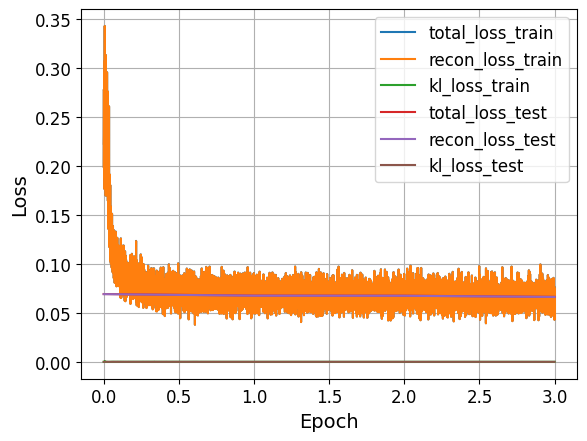

In [21]:
# ====
# choose these parameters
BATCH_SIZE = 16 # any adequate value
EPOCHS = 4     # < 20
LR = 3e-4         # < 1e-3
# ====

model = ARFPriorVAE((3, 32, 32), 16)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, use_cuda=USE_CUDA, epochs=EPOCHS, use_tqdm=True, lr=LR)

plot_training_curves(train_losses, test_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


total_loss: 0.0664
recon_loss: 0.0663
kl_loss: 0.0001


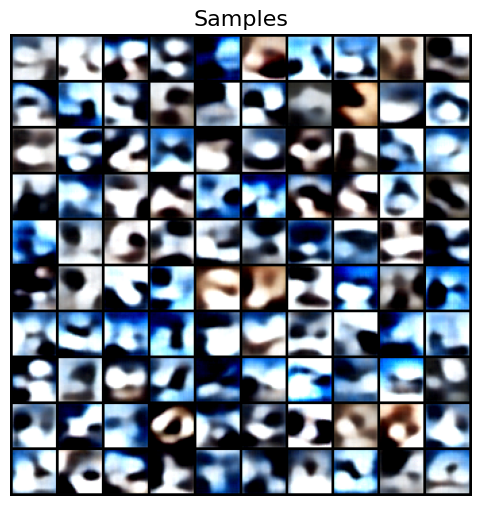

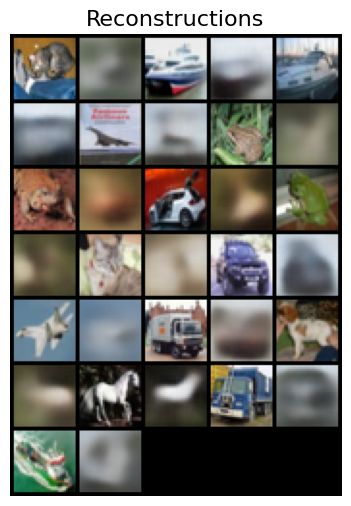

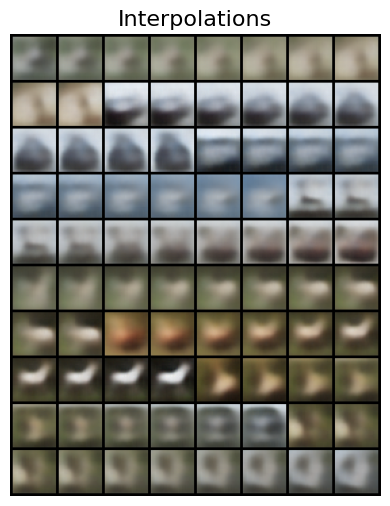

In [22]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]

if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z = model.encoder(2 * x - 1)[0]
    x_recon = torch.clamp(model.decoder(z) * 0.5 + 0.5, 0, 1)

reconstructions = torch.stack((x , x_recon), dim=1).view(-1, 3, 32, 32)
reconstructions = reconstructions.cpu()

x = next(iter(test_loader))[:20]
if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    x = 2 * x - 1
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in torch.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps * 0.5 + 0.5, 0, 1)
interps = interps.cpu()

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
    
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')
show_samples(interps, title='Interpolations')

**Note:** we do not use complicated architectures for encoder and decoder in this task. That is why your samples could be blurry, it is ok. The main goal of this task is to understand the theory around flow-based prior. But of course you could experiment with more complex networks (like ResNet) for additional points.